# Data Analytics SoSe 2021
## Gruppenmitglieder: Anja Stricker, Annika Stadelmann

### Inhaltsverzeichnis

* [Aufgabe 1](#aufgabe1)
    * [Aufgabe 1a](#aufgabe1a)
    * [Aufgabe 1b](#aufgabe1b)
    * [Aufgabe 1c](#aufgabe1c)
    * [Aufgabe 1d](#aufgabe1d)
    * [Aufgabe 1e](#aufgabe1e)
    * [Aufgabe 1f](#aufgabe1f)
    * [Aufgabe 1g](#aufgabe1g)
* [Aufgabe 2](#aufgabe2)
    * [Aufgabe 2a](#aufgabe2a)
    * [Aufgabe 2b](#aufgabe2b)
    * [Aufgabe 2c](#aufgabe2c)
    * [Aufgabe 2d](#aufgabe2d)
    * [Aufgabe 2e](#aufgabe2e)
    * [Aufgabe 2f](#aufgabe2f)
    * [Aufgabe 2g](#aufgabe2g)
* [Aufgabe 3](#aufgabe3)
    * [Aufgabe 3a](#aufgabe3a)
    * [Aufgabe 3b](#aufgabe3b)
    * [Aufgabe 3c](#aufgabe3c)
* [Aufgabe 4](#aufgabe4)
    * [Aufgabe 4a](#aufgabe4a)
    * [Aufgabe 4b](#aufgabe4b)
    * [Aufgabe 4c](#aufgabe4c)
* [Aufgabe 5](#aufgabe5)
* [Aufgabe 6](#aufgabe6)

### Aufgabe 1 <a id="aufgabe1"></a>
#### (Datenvorbereitung)
Lesen Sie den unter der o.g. Adresse verfugbaren Tankstellendatensatz zum Stand 31.05.2021
in einen DataFrame namens df stations ein. Dieser soll in dieser Aufgabe fur die weitere
Verwendung vorbereitet werden.

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="DA_stud")
import json
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

df_stations = pd.read_csv("2021-05-31-stations.csv")
df_stations.head()

uuid                     name    brand  \
0  0e18d0d3-ed38-4e7f-a18e-507a78ad901d  OIL! Tankstelle München     OIL!   
1  44e2bdb7-13e3-4156-8576-8326cdd20459           bft Tankstelle      NaN   
2  ad812258-94e7-473d-aa80-d392f7532218   bft Bonn-Bad Godesberg      bft   
3  e52d755d-4be7-4962-a917-3b0139e6f352          Esso Tankstelle     ESSO   
4  e52a5d92-33c6-4c77-b6cd-ea90ca1c7c62     Friedrich Dankelmann  Markant   

                street house_number post_code     city   latitude  longitude  \
0  Eversbuschstraße 33          NaN     80999  München  48.180700  11.460900   
1       Schellengasse            53     36304  Alsfeld  50.752009   9.279039   
2    Godesberger Allee           55     53175     Bonn  50.695100   7.142760   
3  OSNABRUECKER STR. 5                  49163   BOHMTE  52.358250   8.304064   
4     Strangenhäuschen           10     52070   Aachen  50.801680   6.110960   

             first_active                                  openingtimes_json  
0  1970-01-01 01:00:00+01  {"openingTimes":[{"applicable_days":192,"perio...  
1  1970-01-01 01:00:00+01  {"openingTimes":[{"applicable_days":63,"period...  
2  1970-01-01 01:00:00+01  {"openingTimes":[{"applicable_days":31,"period...  
3  2014-03-18 16:45:31+01  {"openingTimes":[{"applicable_days":31,"period...  
4  2014-03-18 16:45:31+01  {"openingTimes":[{"applicable_days":63,"period...

a) <a id="aufgabe1a"></a> Untersuchen Sie den Datensatz auf fehlende Werte und setzen Sie ggf. eine geeignete Strategie um, um mit diesen zu verfahren. Begrunden Sie Ihr Vorgehen.

In [2]:
df_stations.isnull().sum()

uuid                    0
name                    0
brand                 670
street                  3
house_number         2940
post_code               3
city                    4
latitude                0
longitude               0
first_active            0
openingtimes_json       0
dtype: int64

Im folgenden werden nur noch die Spalten betrachtet die einen NaN Wert über 0 haben.
Alle Spalten mit 0 haben keine NaN Werte und müssen demnach nicht nochmal kontrolliert werden.

NaN Werte werden durch passende andere Werte ersetzt.

In [3]:
df_stations["brand"] = df_stations["brand"].fillna("other")
df_stations["openingtimes_json"] = df_stations["openingtimes_json"].replace("{}", "empty")

In [4]:
df_stations.isnull().sum()

uuid                    0
name                    0
brand                   0
street                  3
house_number         2940
post_code               3
city                    4
latitude                0
longitude               0
first_active            0
openingtimes_json       0
dtype: int64

Jetzt werden fehlende Einträge von street, house_number, city und post_code mit geopy ermittelt und ersetzt.

In [5]:
df = pd.DataFrame()

for i in tqdm(df_stations.loc[df_stations["street"].isnull() | df_stations["city"].isnull() | df_stations["post_code"].isnull()].index):
    data = df_stations.iloc[i]
    if ((data["latitude"] <= 90.0) & (data["latitude"] >= -90.0) & (data["longitude"] <= 180.0) & (data["longitude"] >= -180.0) 
    & (data["latitude"] != 0.0) & (data["longitude"] != 0.0)):
        location = geolocator.reverse(str(data["latitude"]) + ", " + str(data["longitude"]))
        adressData = location.raw["address"]
        if "road" in adressData:
            df_stations.at[i, "street"] = adressData["road"]
        if "town" in adressData:
            df_stations.at[i, "city"] = adressData["town"]
        if "postcode" in adressData:
            df_stations.at[i, "post_code"] = adressData["postcode"]

100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


In [6]:
for i in tqdm(df_stations.loc[df_stations["house_number"].isnull()].index):
    data = df_stations.iloc[i]
    if ((data["latitude"] <= 90.0) & (data["latitude"] >= -90.0) & (data["longitude"] <= 180.0) & (data["longitude"] >= -180.0) 
    & (data["latitude"] != 0.0) & (data["longitude"] != 0.0)):
        location = geolocator.reverse(str(data["latitude"]) + ", " + str(data["longitude"]))
        adressData = location.raw["address"]
        if "house_number" in adressData:
            df_stations.at[i, "house_number"] = adressData["house_number"]

100%|██████████| 2940/2940 [24:32<00:00,  2.00it/s]


In [7]:
df_stations["street"] = df_stations["street"].fillna("")
df_stations["post_code"] = df_stations["post_code"].fillna(0)
df_stations["city"] = df_stations["city"].fillna("")

df_stations.isnull().sum()

uuid                    0
name                    0
brand                   0
street                  0
house_number         1125
post_code               0
city                    0
latitude                0
longitude               0
first_active            0
openingtimes_json       0
dtype: int64

In [8]:
for i in tqdm(df_stations.loc[(df_stations["latitude"] == 0.0) & (df_stations["longitude"] == 0.0)].index):
    data = df_stations.iloc[i]

    if ((data["street"] != "") & (data["post_code"] != "") & (data["city"] != "")):

        loc = (data["street"] + " " + data["post_code"] + " " + data["city"])
        print(loc)
        
        location = geolocator.geocode(loc)        

        if location != None:
            df_stations.at[i, "latitude"] = location.latitude
            df_stations.at[i, "longitude"] = location.longitude

  0%|          | 0/10 [00:00<?, ?it/s]please delete - bitte loeschen 00000 please delete - bitte loeschen
Talstraße 26 58332 Schwelm
100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


In [9]:
df_stations.loc[(df_stations["latitude"] == 0.0) & (df_stations["longitude"] == 0.0)]

uuid                            name  \
12191  183311cd-53cd-4779-a829-3f91a0e2c3e8  please delete - bitte loeschen   
14200  4e8ecfc5-5d0d-4463-901b-6b9ff8fee510                         01_test   
16074  ce830342-ebca-4bf8-9593-653341732a59               Hh Admi-Testkasse   

       brand                          street house_number post_code  \
12191  other  please delete - bitte loeschen            0     00000   
14200  other                                          NaN         0   
16074   OIL!                          Admi55          NaN     12345   

                                 city  latitude  longitude  \
12191  please delete - bitte loeschen       0.0        0.0   
14200                                       0.0        0.0   
16074               Hh Admi-Testkasse       0.0        0.0   

                 first_active openingtimes_json  
12191  2014-03-18 16:45:31+01             empty  
14200  2015-05-27 00:00:01+02             empty  
16074  2020-09-16 08:01:15+02             empty

In [10]:
df_stations.drop(df_stations[(df_stations["latitude"] == 0.0) & (df_stations["longitude"] == 0.0)].index, inplace=True)

In [11]:
df_stations["post_code"] = df_stations["post_code"].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df_stations.dropna(subset = ["post_code"], inplace=True)
np.isnan(df_stations['post_code']).sum()
df_stations["post_code"] = df_stations["post_code"].astype(np.int64)
#TODO nach oben

Prüfen ob Cities NaN sind

Einträge die City, Post_Code und Coordinaten NaN haben werden gelöscht.

Citys die einen NaN Wert haben, aber einen Postcode, werden mit den anderen Postcode einträgen verglichen und erhalten den Namen der City.

In [12]:
def findCityWithPostcode(row):
    test = df_stations["city"][(df_stations["post_code"] == row["post_code"]) & (df_stations["city"].notnull())].item()
    if (len(test) > 0):
        return test
    else:
        return ""
df_stations["city"] = df_stations[["city", "post_code"]].apply(lambda x: findCityWithPostcode(x) if x["city"] is np.nan else x["city"], axis=1)

In [13]:
df_stations["house_number"] = df_stations["house_number"].fillna(0)
# df_stations = df_stations.dropna(subset=["city"])
df_stations.isnull().sum()

uuid                 0
name                 0
brand                0
street               0
house_number         0
post_code            0
city                 0
latitude             0
longitude            0
first_active         0
openingtimes_json    0
dtype: int64

b) <a id="aufgabe1b"></a> Transformieren Sie die Spalten brand, street und city, sodass die Werte jeweils nur
in Großbuchstaben ausgeben werden.

In [14]:
df_stations["brand"] = df_stations["brand"].str.upper()
df_stations["street"] = df_stations["street"].str.upper()
df_stations["city"] = df_stations["city"].str.upper()

In [15]:
df_stations["city"] = df_stations["city"].str.replace(u"Ü", "UE")
df_stations["city"] = df_stations["city"].str.replace(u"Ö", "OE")
df_stations["city"] = df_stations["city"].str.replace(u"Ä", "AE")

c) <a id="aufgabe1c"></a> Uberprüfen Sie, ob der Datensatz Duplikate enth ¨ alt und entfernen Sie diese ggf. Ein Dupli- ¨
kat liege dann vor, wenn zwei Tankstellen in den Spalten name, street, house number
und post code ubereinstimmen. Geben Sie aus, wie viele Duplikate ermittelt und entfernt ¨
wurden.

In [16]:
df_stations[["name", "street", "house_number", "post_code"]].duplicated().sum()

48

In [17]:
df_stations.drop_duplicates(subset = {"name", "street", "house_number", "post_code"}, keep =  "first", inplace = True)
df_stations[["name", "street", "house_number", "post_code"]].duplicated().sum()

0

In [18]:
df_stations.to_csv("df_stations.csv", index=True)

In [19]:
df_stations = pd.read_csv("df_stations.csv")

Es wurden 52 Duplikate ermittelt

d) <a id="aufgabe1d"></a> Untersuchen Sie die Spalten longitude und latitude auf unphysikalische Werte, indem Sie zunachst deren Verteilung in einem Histogramm visualisieren. Entfernen oder kor- ¨
rigieren Sie anschließend die Eintrage zu denjenigen Tankstellen, bei denen Sie unphysi- ¨
kalische Werte festgestellt haben. Zeichnen Sie anschließend erneut Histogramme fur die ¨
beiden Spalten longitude und latitude.

Zuerst analysieren wir die Daten.

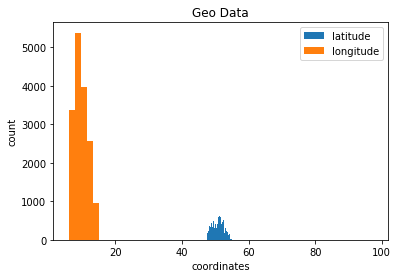

In [20]:
plt.hist(df_stations["latitude"], 50, label='latitude')
plt.hist(df_stations["longitude"], 50, label='longitude')
plt.legend(loc='upper right')
plt.title("Geo Data")
plt.xlabel('coordinates') 
plt.ylabel('count')
plt.show()

Bei Longitude ist ein Ausreißer beim Wert 0 zu erkennen. Diese werden im Folgenden gefiltert.
Ebenso sind unphysikalische Werte zu erkennen, welche ebenfalls korrigiert werden.

In [21]:
df_stations = df_stations.loc[(df_stations["longitude"] != 0.0) & (df_stations["latitude"] != 0.0)]
df_stations = df_stations.loc[(df_stations["latitude"] <= 90.0) & (df_stations["latitude"] >= -90.0) & (df_stations["longitude"] <= 180.0) & (df_stations["longitude"] >= -180.0)]

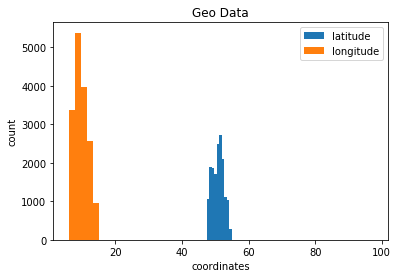

In [22]:
plt.hist(df_stations["latitude"], 10, label='latitude')
plt.hist(df_stations["longitude"], 50, label='longitude')
plt.legend(loc='upper right')
plt.title("Geo Data")
plt.xlabel('coordinates') 
plt.ylabel('count')
plt.show()

Jetzt sehen wir die korrekte Koordinaten Daten

e) <a id="aufgabe1e"></a> Reichern Sie den Tankstellendatensatz um die Spalte state an, die das Bundesland enthalten soll, in dem sich die Tankstelle befindet. Erzeugen Sie durch Filterung einen DataFrame
namens df_stations_BY, der die Informationen zu allen Tankstellen in Bayern enthalt.

In [23]:
df_stations = df_stations.reset_index(drop=True)
df_stations.shape[0]

16247

In [24]:
df_stations[-10:].index

RangeIndex(start=16237, stop=16247, step=1)

In [25]:
df_bundesland_plz = pd.read_csv("zuordnung_plz_ort_landkreis.csv")
df_bundesland_plz.head()

osm_id      ags     ort    plz                 landkreis  \
0  1104550  8335001    Aach  78267        Landkreis Konstanz   
1  1255910  7235001    Aach  54298  Landkreis Trier-Saarburg   
2    62564  5334002  Aachen  52062       Städteregion Aachen   
3    62564  5334002  Aachen  52064       Städteregion Aachen   
4    62564  5334002  Aachen  52066       Städteregion Aachen   

            bundesland  
0    Baden-Württemberg  
1      Rheinland-Pfalz  
2  Nordrhein-Westfalen  
3  Nordrhein-Westfalen  
4  Nordrhein-Westfalen

In [26]:
plz_bundesland_dict = {}

for i, j in zip(df_bundesland_plz.plz, df_bundesland_plz.bundesland):
    plz_bundesland_dict[i] = j
    

In [27]:
df_stations["state"] = df_stations["post_code"].map(plz_bundesland_dict)
df_stations.isnull().sum()

Unnamed: 0            0
uuid                  0
name                  0
brand                 0
street                0
house_number          0
post_code             0
city                  1
latitude              0
longitude             0
first_active          0
openingtimes_json     0
state                39
dtype: int64

In [28]:
for i in tqdm(df_stations.loc[df_stations["state"].isnull()].index):
    data = df_stations.iloc[i]
    location = geolocator.reverse(str(data["latitude"]) + ", " + str(data["longitude"]))
    adressData = location.raw["address"]
    if "state" in adressData:
        df_stations.at[i, "state"] = adressData["state"]

df_stations["state"].isnull().sum()

100%|██████████| 39/39 [00:19<00:00,  2.02it/s]


0

In [30]:
df_stations.to_csv("State_checkpoint.csv", index=False)

In [32]:
df_stations_BY = df_stations.loc[df_stations["state"] == "Bayern"]

In [34]:
df_stations_BY.to_csv("Bayern_checkpoint.csv", index=False)

In [35]:
df_stations = pd.read_csv("State_checkpoint.csv")

In [36]:
df_stations_BY = pd.read_csv("Bayern_checkpoint.csv")

Lesen Sie nun den Preise-Datensatz aus dem GitLab-Repository in einen DataFrame namens
df_prices_BY ein. Dieser wurde durch Filterung der auf der Tankerkonig-Seite verf ¨ ugbaren ¨
Preise-Datensatze erzeugt und enth ¨ alt die Angaben zur historischen Preisen und Preis ¨ anderungen ¨
an den Tankstellen in Bayern im Betrachtungszeitraum zwischen Januar 2018 und Mai 2021.

In [37]:
df_prices_BY = pd.read_csv("prices_BY.csv")

f) <a id="aufgabe1f"></a> Untersuchen Sie die Kraftstoffpreise auf Ausreißer und entfernen Sie diese ggf.

In [38]:
df_prices_BY.head()

date                          station_uuid  diesel  \
0  2018-01-01 00:01:06+01  db9309c1-eb3f-4a2a-92ec-a374262facc9   1.274   
1  2018-01-01 00:02:06+01  446bdcf5-9f75-47fc-9cfa-2c3d6fda1c3b   1.339   
2  2018-01-01 00:03:05+01  a98ed5d0-261b-4311-beaf-85ee779fc4e0   1.289   
3  2018-01-01 00:05:06+01  7fa4a726-3da5-4aca-afdb-161fbbac23b0   1.299   
4  2018-01-01 00:07:06+01  742c6776-9f9e-45c9-87de-b27e3c5677a9   1.249   

      e5    e10  dieselchange  e5change  e10change  
0  0.000  0.000             1         0          0  
1  1.459  1.439             1         1          1  
2  1.439  1.419             1         1          1  
3  1.469  1.449             1         1          1  
4  0.000  0.000             1         0          0

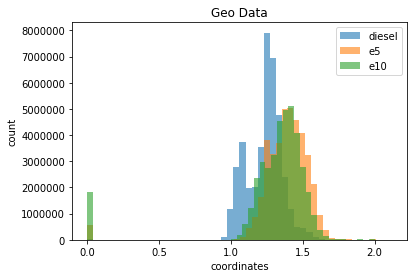

In [39]:
plt.hist(df_prices_BY["diesel"], 50, label='diesel', alpha=0.6)
plt.hist(df_prices_BY["e5"], 50, label='e5', alpha=0.6)
plt.hist(df_prices_BY["e10"], 50, label='e10', alpha=0.6)
plt.legend(loc='upper right')
plt.title("Geo Data")
plt.xlabel('coordinates') 
plt.ylabel('count')
plt.show()

In [40]:
df_prices_BY["e10"] = df_prices_BY["e10"].replace(0.000, np.nan)
df_prices_BY.loc[df_prices_BY["e10"] < 0.5] = np.nan
df_prices_BY["e5"] = df_prices_BY["e5"].replace(0.000, np.nan)
df_prices_BY.loc[df_prices_BY["e5"] < 0.5] = np.nan
df_prices_BY["diesel"] = df_prices_BY["diesel"].replace(0.000, np.nan)
df_prices_BY.loc[df_prices_BY["diesel"] < 0.5] = np.nan

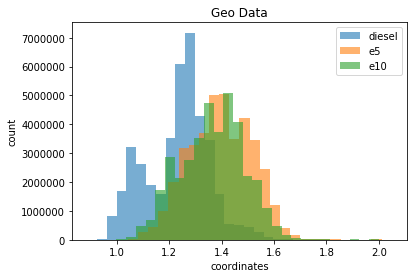

In [41]:
plt.hist(df_prices_BY["diesel"], 30, label='diesel', alpha=0.6)
plt.hist(df_prices_BY["e5"], 30, label='e5', alpha=0.6)
plt.hist(df_prices_BY["e10"], 30, label='e10', alpha=0.6)
plt.legend(loc='upper right')
plt.title("Geo Data")
plt.xlabel('coordinates') 
plt.ylabel('count')
plt.show()

g) <a id="aufgabe1g"></a> Uberf ¨ uhren Sie die Spalte ¨ date in ein DateTime-Format.

In [42]:
df_prices_BY["date"] = pd.to_datetime(df_prices_BY["date"], infer_datetime_format=True, utc=True)
df_prices_BY["date"].head()

0   2017-12-31 23:01:06+00:00
1   2017-12-31 23:02:06+00:00
2   2017-12-31 23:03:05+00:00
3   2017-12-31 23:05:06+00:00
4   2017-12-31 23:07:06+00:00
Name: date, dtype: datetime64[ns, UTC]

### Aufgabe 2 <a id="aufgabe2"></a>
#### (Explorative Datenanalyse)
In dieser Aufgabe sind erste einfache Analysen durchzufuhren und Visualisierungen zu erstellen

a) <a id="aufgabe2a"></a> Wie viele Tankstellen gibt es insgesamt in Deutschland? Wie viele pro Bundesland?

In [43]:
len(df_stations)

16247

In [44]:
df_stations["state"].value_counts()

Nordrhein-Westfalen       3350
Bayern                    2777
Baden-Württemberg         2103
Niedersachsen             2056
Hessen                    1280
Rheinland-Pfalz            859
Schleswig-Holstein         660
Sachsen                    618
Sachsen-Anhalt             476
Brandenburg                459
Thüringen                  443
Mecklenburg-Vorpommern     373
Berlin                     303
Hamburg                    214
Saarland                   172
Bremen                     104
Name: state, dtype: int64

b) <a id="aufgabe2b"></a> Welches sind die zehn Tankstellenmarken mit den meisten Niederlassungen in Deutschland?
Wie viele Niederlassungen sind es jeweils?

In [45]:
meisteMarken = list(df_stations['brand'].value_counts()[0:10].index)

def Convert(lst):
    res_dct = {lst[i]: 0 for i in range(0, len(lst), 1)}
    return res_dct

lst = Convert(meisteMarken)

for x in df_stations["brand"]:
    if x in lst:
        lst[x] += 1

lst

{'ARAL': 2421,
 'SHELL': 1848,
 'ESSO': 1134,
 'TOTAL': 921,
 'AVIA': 730,
 'JET': 697,
 'OTHER': 658,
 'STAR': 577,
 'BFT': 485,
 'AGIP': 457}

c) <a id="aufgabe2c"></a> Welcher Anteil der Tankstellen hat sonntags geoffnet?

In [46]:
openingTimes = df_stations['openingtimes_json']
openOnSunday = {"Sonntags_geöffnet": 0, "Sonntags_geschlossen": 0}
errorData = {"Keine_Öffnungszeit": 0, "Fehlerhaft": 0}

for x in openingTimes:
    if x != "empty":
        if "openingTimes" in json.loads(x):
            foundSunday = False
            for y in json.loads(x)["openingTimes"]:
                bitValue = y["applicable_days"]
                mask = 1 << 6
                if (bitValue & mask == mask):
                    openOnSunday["Sonntags_geöffnet"] += 1
                    foundSunday = True
                    break
            if (foundSunday == False):
                openOnSunday["Sonntags_geschlossen"] += 1
        else:
            errorData["Fehlerhaft"] += 1
    else:
        errorData["Keine_Öffnungszeit"] += 1

openOnSunday

{'Sonntags_geöffnet': 8403, 'Sonntags_geschlossen': 594}

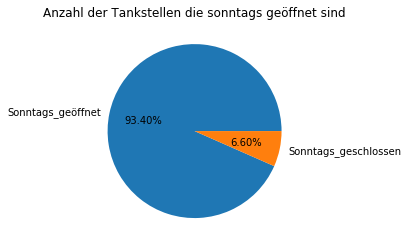

In [47]:
def pie_label_formatter(x):
    return '{:.2f}%'.format(x)

plt.pie(openOnSunday.values(), labels = openOnSunday.keys(), autopct=pie_label_formatter)
plt.title("Anzahl der Tankstellen die sonntags geöffnet sind")
plt.show()

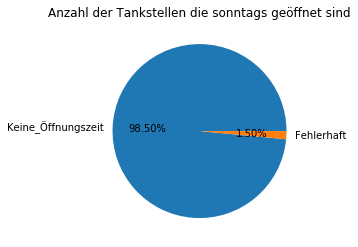

In [48]:
plt.pie(errorData.values(), labels = errorData.keys(), autopct=pie_label_formatter)
plt.title("Anzahl der Tankstellen die sonntags geöffnet sind")
plt.show()

d) <a id="aufgabe2d"></a> Visualisieren Sie in einem Kreisdiagramm die Zusammensetzung des Marktes in freie Tankstellen und Markentankstellen. Nehmen Sie vereinfachend an, dass eine Tankstelle dann
eine freie Tankstelle ist, wenn sie gemaß der Spalte ¨ brand einer Marke angehort, die bun- ¨
desweit hochstens 20 Niederlassungen betreibt.

In [49]:
brand = list(df_stations['brand'].value_counts().index)

def Convert(lst):
    res_dct = {lst[i]: 0 for i in range(0, len(lst), 1)}
    return res_dct

lst = Convert(brand)

for x in df_stations["brand"]:
    if x in lst:
        lst[x] += 1

tankstellenListe = {"Markentankstellen": 0, "Freie Tankstellen": 0}

for x in lst.values():
    if x > 20:
        tankstellenListe["Markentankstellen"] += x
    else:
        tankstellenListe["Freie Tankstellen"] += x
tankstellenListe

{'Markentankstellen': 14422, 'Freie Tankstellen': 1825}

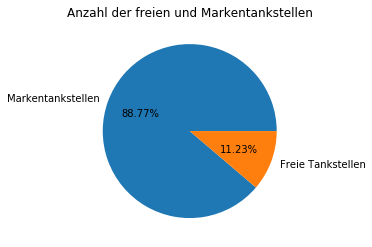

In [50]:
plt.pie(tankstellenListe.values(), labels = tankstellenListe.keys(), autopct=pie_label_formatter)
plt.title("Anzahl der freien und Markentankstellen")
plt.show()

e) <a id="aufgabe2e"></a> Wie haufig wird an den bayerischen Tankstellen durchschnittlich pro Tag im Betrachtungs- ¨
zeitraum ein Datensatz an die Markttransparenzstelle fur Kraftstoffe ¨ ubermittelt? 

In [51]:
TagesDurchschnitt = df_prices_BY["date"].groupby(df_prices_BY["date"].dt.date).count()
TagesDurchschnitt

date
2017-12-31       47
2018-01-01    22767
2018-01-02    26726
2018-01-03    25916
2018-01-04    26315
              ...  
2021-05-27    40995
2021-05-28    41213
2021-05-29    40143
2021-05-30    37518
2021-05-31    39738
Name: date, Length: 1248, dtype: int64

In [52]:
TagesDurchschnitt.mean()

32029.253205128207

f) <a id="aufgabe2f"></a> In welchen zehn bayerischen Stadten war der durchschnittliche Diesel-Preis im Betrach- ¨
tungszeitraum 2018-2021 am hochsten und wie hoch war er jeweils? In welchen zehn ¨
Stadten war er am geringsten und wie hoch war er jeweils? 

In [53]:
combinedStations = df_prices_BY.groupby("station_uuid")["diesel"].mean()

In [54]:
combined_df = pd.DataFrame(combinedStations)
combined_df = combined_df.reset_index()

In [55]:
combined_df.rename(columns = {"station_uuid":"uuid"}, inplace="True")

In [56]:
combined_df = combined_df.merge(df_stations[["uuid", "city"]])
combined_df = combined_df.groupby("city")["diesel"].mean()
combined_df = pd.DataFrame(combined_df)
combined_df = combined_df.reset_index()
#TODO drop 2017

In [57]:
combined_df.to_csv("combined_df.csv")

In [58]:
combined_df.sort_values(by=["diesel"], inplace=True, ascending=False)
combined_df[0:10]

city    diesel
475                    ILLSCHWANG  1.524630
411          HAUSEN BEI WUERZBURG  1.522842
531  KLEINLANGHEIM - HAIDT (SUED)  1.502727
567                LANDSBERG LECH  1.501544
121             BERGEN / CHIEMGAU  1.497545
566             LANDSBERG AM LECH  1.497352
709           NEUFAHRN B.FREISING  1.493707
311                    FUERHOLZEN  1.487962
509                 KIEFERSFELDEN  1.481179
784                     OHRENBACH  1.451928

In [59]:
combined_df.sort_values(by=["diesel"], ascending=True).head(10)

city    diesel
726           NEUSORG  1.052904
1095       WAGENHOFEN  1.101939
517     KIRCHENLAMITZ  1.102472
738   NIEDERFUELLBACH  1.114648
977        SENGENTHAL  1.121639
633    MAROLDSWEISACH  1.138882
310   FUCHSTAL-LEEDER  1.142259
986        SOECHTENAU  1.144537
197    DIEDORF-BIBURG  1.148111
459          HOLZHEIM  1.151712

g) <a id="aufgabe2g"></a> Erstellen Sie mit folium eine interaktive Karte, auf der die einzelnen Tankstellen in Bayern
als Marker (in einem Marker-Cluster) eingezeichnet sind. Beim Klick auf einen Marker soll
der Name der Tankstelle und deren Adresse angezeigt werden.

In [60]:
df_stations_BY.head()

Unnamed: 0                                  uuid  \
0           0  0e18d0d3-ed38-4e7f-a18e-507a78ad901d   
1          15  e4e50be1-a0dd-4d07-95d9-de4d6573cc17   
2          16  e4e48d10-0b37-4ecf-a0bd-552b0302a4af   
3          23  e4b3161b-269e-41f9-8c56-d813a6733668   
4          27  e5bdb1cc-d078-40eb-86f6-35a000c3828c   

                           name        brand                street  \
0       OIL! Tankstelle München         OIL!  EVERSBUSCHSTRASSE 33   
1               Aral Tankstelle         ARAL     AICHACHER STRASSE   
2       Kirchdorf Hauptstraße 1          OMV             HAUPTSTR.   
3        TotalEnergies Muenchen        TOTAL        LEONRODSTR. 48   
4  AVIA XPress Automatenstation  AVIA XPRESS      COBURGER STRASSE   

  house_number  post_code                 city   latitude  longitude  \
0            0      80999             MUENCHEN  48.180700  11.460900   
1           26      86316            FRIEDBERG  48.361404  10.987790   
2            1      85414            KIRCHDORF  48.458410  11.652600   
3            0      80636             MUENCHEN  48.157499  11.543893   
4           36      96237  EBERSDORF B. COBURG  50.222420  11.058580   

             first_active                                  openingtimes_json  \
0  1970-01-01 01:00:00+01  {"openingTimes":[{"applicable_days":192,"perio...   
1  2014-03-18 16:45:31+01  {"openingTimes":[{"applicable_days":1,"periods...   
2  2014-03-18 16:45:31+01  {"openingTimes":[{"applicable_days":31,"period...   
3  2014-03-18 16:45:31+01  {"openingTimes":[{"applicable_days":31,"period...   
4  2014-03-18 16:45:31+01                                              empty   

    state  
0  Bayern  
1  Bayern  
2  Bayern  
3  Bayern  
4  Bayern

In [61]:
df_landkreise = pd.read_csv("zuordnung_plz_ort_landkreis.csv")
df_landkreise.rename(columns = {"plz":"post_code"}, inplace="True")
type(df_landkreise["post_code"][0])

numpy.int64

In [62]:
df_stations_BY = df_stations_BY.merge(df_landkreise[["post_code", "landkreis"]])
df_stations_BY = pd.DataFrame(df_stations_BY)
df_stations_BY = df_stations_BY.reset_index()

In [63]:
landkreise = list(df_stations_BY['landkreis'].value_counts().index)
len(landkreise)

71

In [64]:
m = folium.Map(location=[48.9478033183036, 11.404411169316944], zoom_start=7, tiles="openstreetmap")

for x in landkreise:
    marker_cluster = MarkerCluster(name = x).add_to(m)
    for i in df_stations_BY.loc[df_stations_BY["landkreis"] == x].index:
        folium.Marker([df_stations_BY["latitude"][i], df_stations_BY["longitude"][i]], 
        popup=df_stations_BY["name"][i] + " " + df_stations_BY["street"][i] + " " + str(df_stations_BY["post_code"][i]) + " " + df_stations_BY["city"][i]).add_to(marker_cluster)

In [65]:
m

### Aufgabe 3  <a id="aufgabe3"></a>
#### (Analyse der historischen Entwicklung der Kraftstoffpreise)

a) <a id="aufgabe3a"></a> In welchem Monat im Betrachtungszeitraum waren die Kraftstoffpreise fur Diesel in Bay- ¨
ern durchschnittlich am hochsten? In welchem am geringsten? Wie hoch waren die durch- ¨
schnittlichen Preise jeweils?

In [66]:
monthPrices = df_prices_BY.resample(rule='M', on='date')['diesel'].mean()
monthPrices_df = pd.DataFrame(monthPrices)
monthPrices_df = monthPrices_df.reset_index()

In [67]:
monthPrices_df.sort_values(by=["diesel"], inplace=True, ascending=False)
monthPrices_df.head()

date    diesel
11 2018-11-30 00:00:00+00:00  1.505811
10 2018-10-31 00:00:00+00:00  1.441287
9  2018-09-30 00:00:00+00:00  1.387470
12 2018-12-31 00:00:00+00:00  1.371994
41 2021-05-31 00:00:00+00:00  1.333518

In [68]:
monthPrices_df.tail()

date    diesel
30 2020-06-30 00:00:00+00:00  1.079502
33 2020-09-30 00:00:00+00:00  1.055030
35 2020-11-30 00:00:00+00:00  1.054675
29 2020-05-31 00:00:00+00:00  1.045193
34 2020-10-31 00:00:00+00:00  1.043569

b) <a id="aufgabe3b"></a> Ermitteln Sie die Jahresdurchschnitte fur die einzelnen Kraftstoffsorten in den Jahren 2018- ¨
2021 fur die bayerischen Tankstellen. Visualisieren Sie diese in einem geeigneten Dia- ¨
gramm. Lassen sich Trends erkennen?

In [69]:
yearPrices_diesel = df_prices_BY.resample(rule='Y', on='date')['diesel'].mean()
yearPrices_diesel_df = pd.DataFrame(yearPrices_diesel)
yearPrices_diesel_df = yearPrices_diesel_df.reset_index()

In [70]:
yearPrices_e5 = df_prices_BY.resample(rule='Y', on='date')['e5'].mean()
yearPrices_e5_df = pd.DataFrame(yearPrices_e5)
yearPrices_e5_df = yearPrices_e5_df.reset_index()

In [71]:
yearPrices_e10 = df_prices_BY.resample(rule='Y', on='date')['e10'].mean()
yearPrices_e10_df = pd.DataFrame(yearPrices_e10)
yearPrices_e10_df = yearPrices_e10_df.reset_index()

In [72]:
merged_year_prices = yearPrices_diesel_df
merged_year_prices = merged_year_prices.merge(yearPrices_e5_df, on="date")
merged_year_prices = merged_year_prices.merge(yearPrices_e10_df, on="date")

merged_year_prices

date    diesel        e5       e10
0 2017-12-31 00:00:00+00:00  1.276766  1.438556  1.417667
1 2018-12-31 00:00:00+00:00  1.311784  1.463215  1.441391
2 2019-12-31 00:00:00+00:00  1.285718  1.436302  1.414659
3 2020-12-31 00:00:00+00:00  1.114651  1.284120  1.250197
4 2021-12-31 00:00:00+00:00  1.294346  1.477144  1.421118

In [73]:
merged_year_prices["date"] = merged_year_prices['date'].dt.strftime('%Y')

In [74]:
merged_year_prices.sort_values(by=["date"], inplace=True, ascending=True)

In [75]:
merged_year_prices

date    diesel        e5       e10
0  2017  1.276766  1.438556  1.417667
1  2018  1.311784  1.463215  1.441391
2  2019  1.285718  1.436302  1.414659
3  2020  1.114651  1.284120  1.250197
4  2021  1.294346  1.477144  1.421118

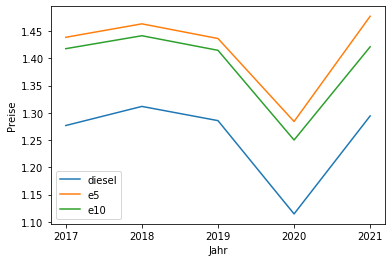

In [76]:
plt.plot("date", "diesel", data=merged_year_prices)
plt.plot("date", "e5", data=merged_year_prices)
plt.plot("date", "e10", data=merged_year_prices)
plt.xlabel("Jahr")
plt.ylabel("Preise")
plt.legend()
plt.show()

c) <a id="aufgabe3c"></a> Visualisieren Sie auf geeignete Weise den zeitlichen Verlauf der Preise fur die Kraftstoffe ¨
Diesel und Super E5 und Super E10 an den bayerischen Tankstellen zwischen 2018 und
2021. Beschreiben und interpretieren Sie Ihre Beobachtungen.

In [77]:
dayprices = df_prices_BY.resample(rule="D", on="date")[["diesel", "e5", "e10"]].mean()

In [78]:
dayprices

diesel        e5       e10
date                                                   
2017-12-31 00:00:00+00:00  1.276766  1.438556  1.417667
2018-01-01 00:00:00+00:00  1.232033  1.383470  1.361775
2018-01-02 00:00:00+00:00  1.222631  1.375573  1.353492
2018-01-03 00:00:00+00:00  1.222767  1.373358  1.351382
2018-01-04 00:00:00+00:00  1.223331  1.373950  1.351692
...                             ...       ...       ...
2021-05-27 00:00:00+00:00  1.343710  1.543245  1.484203
2021-05-28 00:00:00+00:00  1.342620  1.543344  1.484252
2021-05-29 00:00:00+00:00  1.344669  1.544759  1.485630
2021-05-30 00:00:00+00:00  1.346351  1.547806  1.488683
2021-05-31 00:00:00+00:00  1.342343  1.544668  1.485729

[1248 rows x 3 columns]

In [79]:
dayprices = dayprices.reset_index()

In [80]:
dayprices["date"] = dayprices['date'].dt.strftime('%Y-%m-%d')

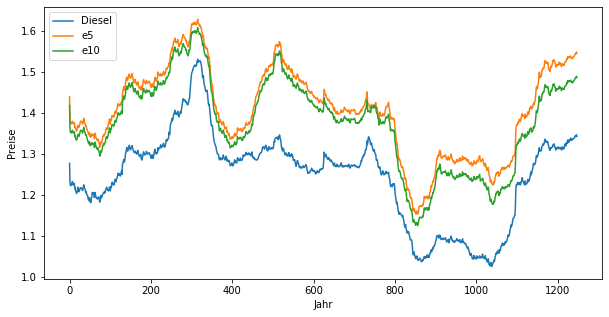

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(dayprices["diesel"], label="Diesel")
plt.plot(dayprices["e5"], label="e5")
plt.plot(dayprices["e10"], label="e10")
plt.xlabel("Jahr")
plt.ylabel("Preise")
plt.legend()
plt.show()

### Aufgabe 4 <a id="aufgabe4"></a>
#### (Abhangigkeit zwischen dem Roh ¨ olpreis und den Kraftstoffpreisen)

a) <a id="aufgabe4a"></a> Untersuchen Sie jeweils den Zusammenhang zwischen den Kraftstoffpreisen fur Diesel bzw. ¨
Super E5 und dem Roholpreis. Berechnen Sie dazu die Tagesmittelwerte f ¨ ur die Kraftstoff- ¨
preise fur alle Tage im Betrachtungszeitraum 2018-2021 (f ¨ ur die bayerischen Tankstellen) ¨
und stellen Sie diese jeweils den Tagesschlusskursen fur die Roh ¨ olsorte Brent Crude Oil ¨
(offentlich verf ¨ ugbar) in zwei Streudiagrammen (eines f ¨ ur Diesel und eines f ¨ ur E5) ge- ¨
genuber. Laden Sie die verwendeten ¨ Olpreis-Daten in Form einer CSV-Datei mit Ihrer Ab- ¨
gabe auf Moodle hoch.

https://www.finanzen.net/rohstoffe/oelpreis/historisch/euro?type=Brent
https://www.convertcsv.com/csv-to-csv.htm
HISTORISCHE ÖLPREIS (BRENT) TABELLE IN EUR JE BARREL

159l = 1barrel

In [82]:
brent_preise = pd.read_csv("Brent_Crude_öl_preise.csv")
brent_preise['Datum'] = pd.to_datetime(brent_preise['Datum'], errors='coerce', utc=True)
brent_preise["Datum"] = brent_preise['Datum'].dt.strftime('%Y-%m-%d')

In [83]:
brent_preise

Datum  Schluss  Eröffnung  Tageshoch  Tagestief
0    2021-05-28    57.10      57.15      57.34      56.80
1    2021-05-27    56.96      56.40      57.00      55.85
2    2021-05-26    56.47      56.20      56.71      55.77
3    2021-05-25    56.04      55.89      56.24      55.37
4    2021-05-24    56.03      54.61      56.18      54.39
..          ...      ...        ...        ...        ...
877  2018-08-01    56.62      56.64      56.80      56.34
878  2018-05-01    56.21      56.51      56.62      55.91
879  2018-04-01    56.39      56.24      56.55      56.01
880  2018-03-01    56.46      55.38      56.62      55.26
881  2018-02-01    55.21      55.20      55.81      54.94

[882 rows x 5 columns]

In [84]:
brent_preise.rename(columns = {"Datum":"date"}, inplace="True")

In [85]:
mergeDiesel = brent_preise.merge(dayprices, on="date")

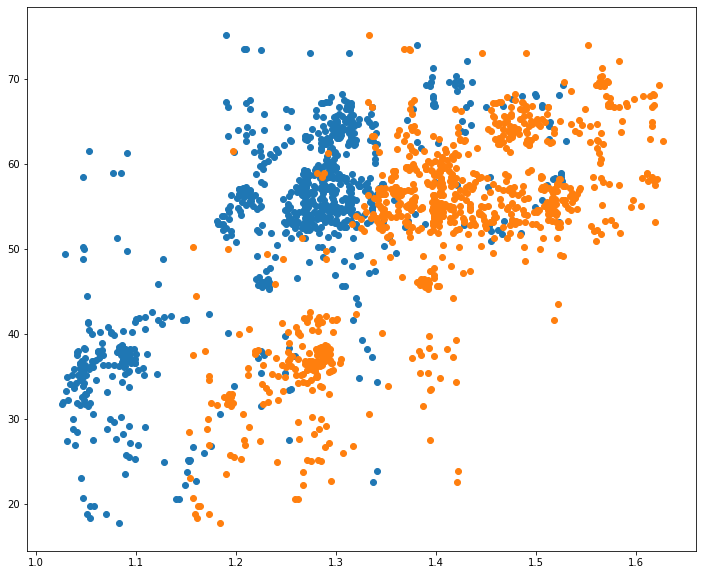

In [86]:
#import matplotlib.colors as mcolors

plt.figure(figsize=(12,10))
plt.scatter(mergeDiesel["diesel"], mergeDiesel["Schluss"])
plt.scatter(mergeDiesel["e5"], mergeDiesel["Schluss"])
    
plt.show()

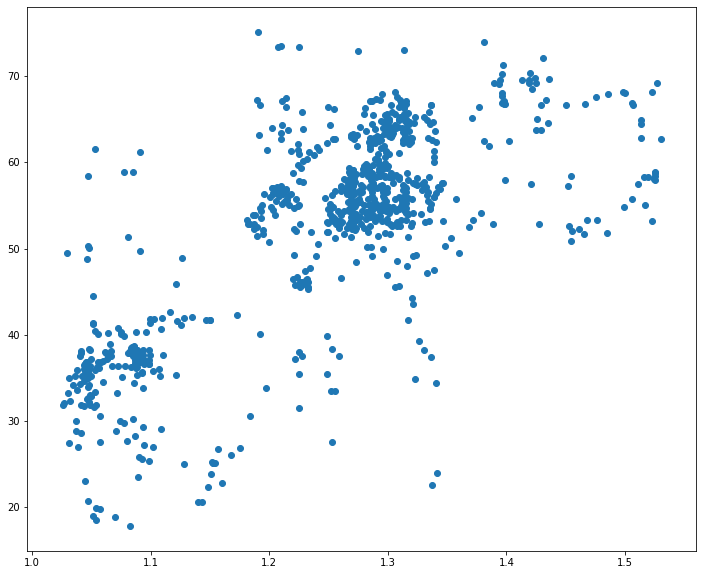

In [87]:
import matplotlib.colors as mcolors

plt.figure(figsize=(12,10))
plt.scatter(mergeDiesel["diesel"], mergeDiesel["Schluss"])
    
plt.show()

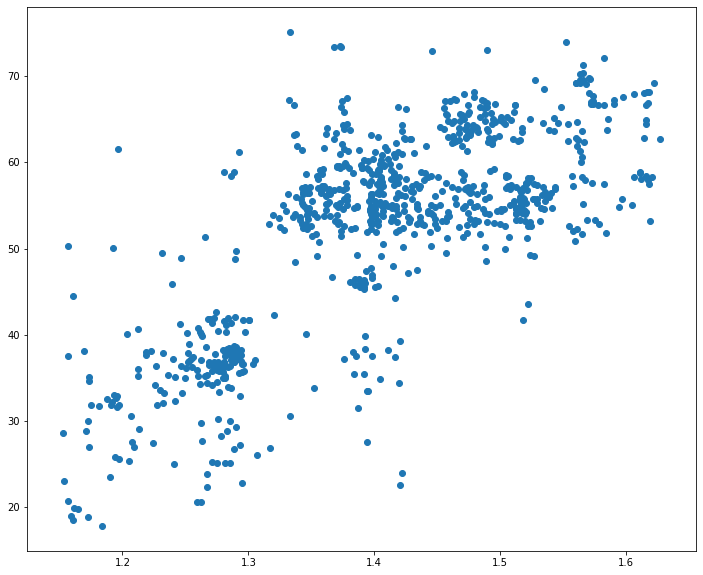

In [88]:
import matplotlib.colors as mcolors

plt.figure(figsize=(12,10))
plt.scatter(mergeDiesel["e5"], mergeDiesel["Schluss"])
    
plt.show()

b) <a id="aufgabe4b"></a> Berechnen Sie jeweils fur Diesel und E5 den empirischen Korrelationskoeffizienten zwi- ¨
schen den Roholpreisen und den Tagesmittelwerten der Kraftstoffpreise.

In [91]:
#TODO

c) <a id="aufgabe4c"></a> Diskutieren Sie, ob lineare Modelle sinnvoll waren, um die Zusammenh ¨ ange zwischen dem ¨
Roholpreis und den Preisen f ¨ ur Diesel bzw. E5 darzustellen.

In [44]:
#TODO

### Aufgabe 5 <a id="aufgabe5"></a>
#### (Einfluss des Wettbewerbs auf die Kraftstoffpreise in Bayern)
Untersuchen Sie, welchen Einfluss der Wettbewerb zwischen mehreren Tankstellen auf die Preisgestaltung hat. Ermitteln Sie dazu zunachst f ¨ ur jede Tankstelle in Bayern, wie viele Tankstellen ¨
sich im Umkreis von 5km Umgebung zu ihr befindet. Speichern Sie diese Angabe in einer Spalte namens neighbors. Speichern Sie den resultierenden DataFrame df stations BY als
CSV-Datei namens stations BY.csv und laden Sie diese mit Ihrer Abgabe auf Moodle hoch.
Stellen Sie zunachst m ¨ ogliche Hypothesen auf und untersuchen Sie diese anschließend, indem Sie ¨
geeignete Auswertungen und Visualisierungen erstellen.

In [45]:
#TODO

### Aufgabe 6 <a id="aufgabe6"></a>
#### (Tanken in Amberg, Interaktives Diagramm)
Herr Sparfuchs, der als Rentner zeitlich flexibel ist, mochte wissen, wann und wo er in Am- ¨
berg derzeit am gunstigsten tanken kann. Erstellen Sie dazu ein geeignetes interaktives Dia- ¨
gramm mit Plotly, um die Kraftstoffpreise an den Tankstellen in Amberg zu analysieren, und
leiten Sie Empfehlungen fur Herrn Sparfuchs ab. Erstellen Sie f ¨ ur die Analyse zwei DataFrames ¨
namens df stations amberg und df prices amberg, die aus Filterung der Tankstellenund Preisdatensatze hervorgehen, und verwenden Sie ausschließlich diese f ¨ ur die Erzeugung des ¨
Plotly-Diagramms. Dokumentieren Sie Ihre Analyseergebnisse.

In [46]:
#TODO